# ECM-MPT Data Analysis

 The following notebook will go through prediction analysis for the Extracellular-Matrix Multiple Particle Tracking (ECM-MPT) study of pup age in P14, P21, P28, and P35 datasets.


## Table of Contents


  [1.   Load Data](#1.-load-data)<br />
  [2.   Analysis](#2.-analysis)<br />
  [3.   Modelling](#modelling)<br />
  [4.   Evaluate Results](#evaluate-results)<br />

---

## 1.   Load Data

Loading feature dataset from ECM_CSVS folder: p14, p21, p28, data are designated with their repective age while p35 data is designated with NT_brain_2.

There are 15 total videos from each age group.

In [2]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as pl


from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

#Trying to get xgboost to work oops
#export PYTHONPATH=~/xgboost/python_package

import xgboost as xgb
#from xgboost import cv

import shap

In [3]:
!pwd

/Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks


In [4]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [5]:
dataset_path = workbookDir + '/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]

In [6]:
filelist

['features_P70_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v2.csv',
 'features_P70_40nm_s3_v2.csv',
 'features_P14_40nm_s1_v5.csv',
 'features_P70_40nm_s1_v5.csv',
 'features_P14_40nm_s3_v1.csv',
 'features_P70_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v1.csv',
 'features_P14_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v5.csv',
 '.DS_Store',
 'features_P14_40nm_s3_v5.csv',
 'features_P14_40nm_s3_v4.csv',
 'features_P70_40nm_s1_v1.csv',
 'features_P70_40nm_s3_v4.csv',
 'features_P14_40nm_s1_v1.csv',
 'features_P14_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v2.csv',
 'features_P14_40nm_s1_v2.csv',
 'features_NT_brain_2_slice_1_vid_4.csv',
 'features_P28_40nm_s2_v5.csv',
 'features_P21_40nm_s2_v1.csv',
 'features_P28_40nm_s2_v4.csv',
 'features_NT_brain_2_slice_1_vid_5.csv',
 'features_P21_40nm_s2_v3.csv',
 'features_P21_40nm_s2_v2.csv',
 'features_P28_40nm_s2_v3.csv',
 'features_NT_brain_2_slice_1_vid_2.csv',
 'features_NT_brain_2_slice_

In [7]:
fstats_tot = None
video_num = 0
for filename in filelist:
    try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
            print('Skipped!: {}'.format(filename))

features_P70_40nm_s3_v3.csv size: (2322, 23)
Error, no target
features_P14_40nm_s3_v3.csv size: (323, 91)
features_P14_40nm_s3_v2.csv size: (243, 91)
features_P70_40nm_s3_v2.csv size: (1401, 23)
Error, no target
features_P14_40nm_s1_v5.csv size: (268, 91)
features_P70_40nm_s1_v5.csv size: (17, 23)
Error, no target
features_P14_40nm_s3_v1.csv size: (151, 91)
features_P70_40nm_s1_v4.csv size: (21, 23)
Error, no target
features_P70_40nm_s3_v1.csv size: (2625, 23)
Error, no target
features_P14_40nm_s1_v4.csv size: (140, 91)
features_P70_40nm_s3_v5.csv size: (4162, 23)
Error, no target
Skipped!: .DS_Store
features_P14_40nm_s3_v5.csv size: (389, 91)
features_P14_40nm_s3_v4.csv size: (113, 91)
features_P70_40nm_s1_v1.csv size: (27, 23)
Error, no target
features_P70_40nm_s3_v4.csv size: (2909, 23)
Error, no target
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P70_40nm_s1_v3.csv size: (25, 23)
Error, no target
features_P70_40nm_s1_v2.csv size: 

In [8]:
fstats_tot.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age
0,1.377828,1.466714,0.345123,NaN,0.347071,273.081589,11.597396,1.247060,0.0,456.755044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.844000,34.234700,9.878498,NaN,0.441034,323.044089,13.495678,1.452336,1.0,307.691753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.022024,0.283085,1.399129,NaN,-0.040681,273.148417,9.537690,1.049243,2.0,240.963795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.448351,0.000021,1.842264,NaN,0.003731,313.467054,13.555223,1.444834,3.0,209.178269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.441644,0.054312,2.066218,0.36868,0.017288,278.409074,13.849725,1.172745,4.0,213.264787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.   Analysis

The following columns are present within the downloaded datasets:

In [9]:
fstats_tot.columns

Index(['AR', 'D_fit', 'Deff1', 'Deff2', 'MSD_ratio', 'Mean_Intensity',
       'Quality', 'SN_Ratio', 'Track_ID', 'X', 'Y', 'alpha', 'asymmetry1',
       'asymmetry2', 'asymmetry3', 'boundedness', 'efficiency', 'elongation',
       'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness',
       'Video Number', 'angle_mean', 'angle_mag_mean', 'angle_var',
       'convex_hull', 'convex_hull_norm', 'dist_tot', 'dist_net',
       'progression', 'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit',
       'Mean kurtosis', 'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1',
       'Mean asymmetry2', 'Std asymmetry2', 'Mean asymmetry3',
       'Std asymmetry3', 'Mean AR', 'Std AR', 'Mean elongation',
       'Std elongation', 'Mean boundedness', 'Std boundedness',
       'Mean fractal_dim', 'Std fractal_dim', 'Mean trappedness',
       'Std trappedness', 'Mean efficiency', 'Std efficiency',
       'Mean straightness', 'Std straightness', 'Mean MSD_ratio',
       'Std MSD_ratio', 'Me

Many of these features are not useful for prediction or have data which may negatively impact classification. The following features and the target feature are defined in the following cell. We also remove any datapoints that are empty or infinite:

In [10]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    'angle_mag_mean', # Magnitude of the turning angle mean
    'angle_var', # Variance of the turning angle
    'dist_tot', # Total distance of the trajectory
    'dist_net', # Net distance from first point to last point
    'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [11]:
# Showing a piece of our data:
ecm.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age
0,1.377828,1.466714,0.345123,NaN,0.347071,273.081589,11.597396,1.247060,0.0,456.755044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.844000,34.234700,9.878498,NaN,0.441034,323.044089,13.495678,1.452336,1.0,307.691753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.022024,0.283085,1.399129,NaN,-0.040681,273.148417,9.537690,1.049243,2.0,240.963795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.448351,0.000021,1.842264,NaN,0.003731,313.467054,13.555223,1.444834,3.0,209.178269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.441644,0.054312,2.066218,0.36868,0.017288,278.409074,13.849725,1.172745,4.0,213.264787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before prediction, it is required to balance data. As shown, The current dataset is highly imbalance with most datapoints belonging to P21 and P35 categories. The dataset is reduced using random sampling of each target category.

In [12]:
#------------------ADDED-----------------------------
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        if name > 0: # Needed to do remove nan as a name
            df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        #print(len(df_target[i][1]))
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (14.0:35.0:28.0:21.0) = 6416:17169:6194:20665
Ratio after balance (14.0:35.0:28.0:21.0) = 6194:6194:6194:6194


In [13]:
# ecm_14 = ecm[ecm[target] == 14]
# ecm_21 = ecm[ecm[target] == 21]
# ecm_28 = ecm[ecm[target] == 28]
# ecm_35 = ecm[ecm[target] == 35]
# print(f"Ratio before data balance (P14:P21:P28:P35) = {len(ecm_14)}:{len(ecm_21)}:{len(ecm_28)}:{len(ecm_35)}")
# ecm_list = [ecm_14, ecm_21, ecm_28, ecm_35]
# for i in range(len(ecm_list)):
#     ratio = min([len(i) for i in ecm_list])/len(ecm_list[i])
#     ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
# print(f"Ratio after balance (P14:P21:P28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}:{len(ecm_list[3])}")
# bal_ecm = pd.concat(ecm_list)

## 3.   Modelling

The model used for this study is an extreme gradient boosting (XGBoost) decision tree which is a boosted decision tree. This model was used due to its past results within competitions and research.

Due to the use of statistical surroundings in our feature analysis, binning is required in order to avoid data leakage between training/testing. The followingcode will implement binning and a checkerboard implementation to select certain bins for the training dataset.

In [14]:
# Using checkerboard binning for data split:
# def checkerboard(size):
#     rows = int(size/2)
#     checks = list(range(0, size*size, size+1))
#     for i in range(1, rows):
#         ssize = size - 2*i
#         for j in range(0, ssize):
#             checks.append(2*i + (size+1)*j)
#     for i in range(1, rows):
#         ssize = size - 2*i
#         for j in range(0, ssize):
#             checks.append(size*size - 1 - (2*i + (size+1)*j))
#     checks.sort()
#     return checks

In [15]:
# Old method
# bins = list(range(0, 2048+1, 256))
# bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)
# bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)
# bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
# bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
# bal_ecm['bins'] = bal_ecm['bins'].astype(int)

# cols = bal_ecm.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# bal_ecm = bal_ecm[cols]

In [16]:
# def bin_data(data, ):
#     pass

resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

# cols = bal_ecm.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# bal_ecm = bal_ecm[cols]

In [17]:
# Checkerboard method
# seed = 1234
# np.random.seed(seed)
# test_val_split = 0.5

# le = preprocessing.LabelEncoder()
# bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])
# X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard((len(bins)-1)))].reset_index()
# X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard((len(bins)-1)))].reset_index()
# y_train = X_train['encoded_target']
# X_val, X_test = train_test_split(X_test_val, test_size=test_val_split, random_state=seed)
# y_test = X_test['encoded_target']
# y_val = X_val['encoded_target']
# dtrain = xgb.DMatrix(X_train[features], label=y_train)
# dtest = xgb.DMatrix(X_test[features], label=y_test)
# dval = xgb.DMatrix(X_val[features], label=y_val)

In [18]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [19]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 24776
Training: 12372 (0.499%)
Testing: 6202 (0.250%)
Evaluation: 6202 (0.250%)


Model parameters are based on the best possible XGBoost parameters to minimize logloss error.

In [20]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [21]:
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# model = XGBClassifier()

In [22]:
# model.predict(X_test[features])

In [23]:
features

['alpha',
 'D_fit',
 'kurtosis',
 'asymmetry1',
 'asymmetry2',
 'asymmetry3',
 'AR',
 'elongation',
 'boundedness',
 'fractal_dim',
 'trappedness',
 'efficiency',
 'straightness',
 'MSD_ratio',
 'frames',
 'Deff1',
 'Deff2',
 'angle_mean',
 'angle_mag_mean',
 'angle_var',
 'dist_tot',
 'dist_net',
 'progression',
 'Mean alpha',
 'Mean D_fit',
 'Mean kurtosis',
 'Mean asymmetry1',
 'Mean asymmetry2',
 'Mean asymmetry3',
 'Mean AR',
 'Mean elongation',
 'Mean boundedness',
 'Mean fractal_dim',
 'Mean trappedness',
 'Mean efficiency',
 'Mean straightness',
 'Mean MSD_ratio',
 'Mean Deff1',
 'Mean Deff2']

In [24]:
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException

def cv(params, X_train, y_train, features=None, num_boost_round=20, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For ``n`` folds, **folds** should be a length ``n`` list of tuples.
        Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
        as the training samples for the ``n`` th fold and ``out`` is a list of
        indices to be used as the testing samples for the ``n`` th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Cross-Validation metric (average of validation
        metric computed over CV folds) needs to improve at least once in
        every **early_stopping_rounds** round(s) to continue training.
        The last entry in the evaluation history will represent the best iteration.
        If there's more than one metric in the **eval_metric** parameter given in
        **params**, the last metric will be used for early stopping.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using
        :ref:`Callback API <callback_api>`.
        Example:

        .. code-block:: python

            [xgb.callback.reset_learning_rate(custom_rates)]
    shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
    if isinstance(metrics, str):
        metrics = [metrics]
    if not features:
        features = X_train.columns
    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())
    if (not metrics) and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]
    params.pop("eval_metric", None)
    results = {}
    # create folds in data
    cvfolds, wt_list = mknfold(X_train, y_train, nfold, params, metrics, features)
    
    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    elif isinstance(verbose_eval, int):
        callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))
    callbacks_before_iter = [
        cb for cb in callbacks if
        cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if
        not cb.__dict__.get('before_iteration', False)]
    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds], wt_list)
        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results:
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results

In [25]:
def bin_fold(X_train, nfold):
    bin_list = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

def mknfold(X_train, y_train, nfold, param, evals=(), features=None):
    if not features:
        features = X_train.columns
    dall = xgb.DMatrix(X_train[features], label=y_train)
    out_idset, wt_list = bin_fold(X_train, nfold)
    in_idset = [np.concatenate([out_idset[i] for i in range(nfold) if k != i]) for k in range(nfold)]
    evals = list(evals)
    ret = []
    for k in range(nfold):
        # perform the slicing using the indexes determined by the above methods
        x_train_snip = X_train.loc[in_idset[k]][features]
        y_train_snip = X_train.loc[in_idset[k]]['encoded_target']        
        x_test_snip = X_train.loc[out_idset[k]][features]
        y_test_snip = X_train.loc[out_idset[k]]['encoded_target']
        dtrain = xgb.DMatrix(x_train_snip, label=y_train_snip)
        dtest = xgb.DMatrix(x_test_snip, label=y_test_snip)
        tparam = param
        plst = list(tparam.items()) + [('eval_metric', itm) for itm in evals]
        ret.append(CVPack(dtrain, dtest, plst))
    return ret, wt_list

In [26]:
from xgboost.core import STRING_TYPES

def aggcv(rlist, wt_list):
    # pylint: disable=invalid-name
    """
    Aggregate cross-validation results.

    If verbose_eval is true, progress is displayed in every call. If
    verbose_eval is an integer, progress will only be displayed every
    `verbose_eval` trees, tracked via trial.
    """
    cvmap = {}
    idx = rlist[0].split()[0]
    for line in rlist:
        arr = line.split()
        assert idx == arr[0]
        for metric_idx, it in enumerate(arr[1:]):
            if not isinstance(it, STRING_TYPES):
                it = it.decode()
            k, v = it.split(':')
            if (metric_idx, k) not in cvmap:
                cvmap[(metric_idx, k)] = []
            cvmap[(metric_idx, k)].append(float(v))
    msg = idx
    results = []
    for (metric_idx, k), v in sorted(cvmap.items(), key=lambda x: x[0][0]):
        v = np.array(v)
        if not isinstance(msg, STRING_TYPES):
            msg = msg.decode()
        mean = np.average(v, weights=wt_list)
        std = np.average((v-mean)**2, weights=wt_list)
        results.extend([(k, mean, std)])
    return results

In [30]:
X_train['Deff2'].shape

(12372,)

In [26]:
cv_results = cv(param, X_train, y_train, features, num_boost_round=2000, nfold=5, early_stopping_rounds=3, metrics={'mlogloss'})
cv_results

In [17]:
from scipy.stats import skewnorm
a=10
data = [round(i, 3) for i in skewnorm.rvs(a, size=10, random_state=seed)*0.3]
data

[0.175, 0.326, 0.456, 0.154, 0.225, 0.265, 0.269, 0.181, 0.044, 0.716]

In [18]:
seed = 1234
np.random.seed(seed)

In [19]:
param

{'max_depth': 3,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 4,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss'}

In [20]:
import operator
import numpy as np

def xgb_paramsearch(X_train, y_train, features, init_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics=None, **kwargs):
    params = {**init_params}
    if 'use_gpu' in kwargs and kwargs['use_gpu']:
        # GPU integration will cut cv time in ~half:
        params.update({'gpu_id' : 0,
                       'tree_method': 'gpu_hist',
                       'predictor': 'gpu_predictor'})
    if 'metrics' not in kwargs:
        metrics = {params['eval_metric']}
    else:
        metrics.add(params['eval_metric'])
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        eval_f = operator.gt
    else: 
        eval_f = operator.lt
    if 'early_break' not in kwargs:
        early_break = 5
    else: 
        early_break = kwargs['early_break']
    if 'thresh' not in kwargs:
        thresh = 0.01
    else: 
        thresh = kwargs['thresh']
    if 'seed' not in kwargs:
        seed = 1111
    else:
        seed = kwargs['seed']
    best_param = params
    best_model = cv(params, 
                    X_train, 
                    y_train, 
                    features, 
                    nfold=nfold, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, 
                    metrics=metrics)
    best_eval = best_model[f"test-{params['eval_metric']}-mean"].min()
    best_boost_rounds = best_model[f"test-{params['eval_metric']}-mean"].idxmin()
    
    def _gs_helper(var1n, var2n, best_model, best_param, best_eval, best_boost_rounds):
        local_param = {**best_param}
        for var1, var2 in gs_params:
            print(f"Using CV with {var1n}={{{var1}}}, {var2n}={{{var2}}}")
            local_param[var1n] = var1
            local_param[var2n] = var2
            cv_model = cv(local_param, 
                          X_train, 
                          y_train, 
                          features, 
                          nfold=nfold, 
                          num_boost_round= num_boost_round, 
                          early_stopping_rounds=early_stopping_rounds, 
                          metrics=metrics)
            cv_eval = cv_model[f"test-{local_param['eval_metric']}-mean"].min()
            boost_rounds = cv_model[f"test-{local_param['eval_metric']}-mean"].idxmin()
            if(eval_f(cv_eval, best_eval)):
                best_model = cv_model
                best_param[var1n] = var1
                best_param[var2n] = var2
                best_eval = cv_eval
                best_boost_rounds = boost_rounds
                print(f"New best param found: "
                      f"{local_param['eval_metric']} = {{{best_eval}}}, "
                      f"boost_rounds = {{{best_boost_rounds}}}")
        return best_model, best_param, best_eval, best_boost_rounds
    
    while(early_break >= 0):
        np.random.seed(seed)
        best_eval_init = best_eval
        gs_params = {
            (subsample, colsample)
            for subsample in np.random.choice([i/10. for i in range(5,11)], 3)
            for colsample in np.random.choice([i/10. for i in range(5,11)], 3)
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('subsample', 
                                                                          'colsample_bytree', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (max_depth, min_child_weight)
            for max_depth in [10] + list(np.random.randint(1, 10, 3))
            for min_child_weight in [0, 10] + list(np.random.randint(0, 10, 3))
        }
        best_model, 
        best_param, 
        best_eval, 
        best_boost_rounds = _gs_helper('max_depth', 
                                                                          'min_child_weight', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('eta', 
                                                                          'gamma', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        if (abs(best_eval_init - best_eval) < thresh):
            early_break-=1
        seed+=1
    return best_model, best_param, best_eval, best_boost_rounds


In [35]:
best_model, best_param, best_eval, best_boost_rounds = xgb_paramsearch(X_train, y_train, features, init_params=param, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mlogloss', 'merror'}, use_gpu='True')

KeyboardInterrupt: 

In [26]:
cv_model = cv(param, 
              X_train, 
              y_train, 
              features=features, 
              nfold=5, 
              num_boost_round=2000,
              early_stopping_rounds=3, 
              metrics={'mlogloss', 'merror'}) 

In [27]:
cv_model[f"test-merror-mean"].min()

0.5478588632150847

In [28]:
param['alpha'] = 50

In [29]:
cv_model[f"test-merror-mean"].min()

0.5478588632150847

In [59]:
best_boost_rounds = cv_model[f"test-mlogloss-mean"].idxmin()


In [60]:
best_boost_rounds

15

In [32]:
tst = [(dtrain, 'train')]

In [33]:
label

NameError: name 'label' is not defined

In [34]:
# evals = [(dtrain, 'train'), (dval, 'eval')]
# num_round = best_boost_rounds
# bst = xgb.train(param, dtrain, num_round, evals, )


# ######
# label = dtest.get_label()
# ypred1 = booster.predict(dtest)
# # by default, we predict using all the trees
# pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
# print("Accuracy:",metrics.accuracy_score(label, pred))
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc
booster, acc = train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds)


[0]	train-mlogloss:1.38564	eval-mlogloss:1.38568
[1]	train-mlogloss:1.38519	eval-mlogloss:1.38525
[2]	train-mlogloss:1.38455	eval-mlogloss:1.38466
[3]	train-mlogloss:1.38387	eval-mlogloss:1.38401
[4]	train-mlogloss:1.38338	eval-mlogloss:1.38358
[5]	train-mlogloss:1.38285	eval-mlogloss:1.38308
[6]	train-mlogloss:1.38227	eval-mlogloss:1.38252
[7]	train-mlogloss:1.38169	eval-mlogloss:1.38194
[8]	train-mlogloss:1.38112	eval-mlogloss:1.38140
[9]	train-mlogloss:1.38055	eval-mlogloss:1.38086
[10]	train-mlogloss:1.37999	eval-mlogloss:1.38033
[11]	train-mlogloss:1.37940	eval-mlogloss:1.37979
[12]	train-mlogloss:1.37877	eval-mlogloss:1.37920
[13]	train-mlogloss:1.37833	eval-mlogloss:1.37879
[14]	train-mlogloss:1.37792	eval-mlogloss:1.37841
Accuracy: 0.40734094616639477


In [41]:
bst = xgb.XGBClassifier()
booster = xgb.Booster({'nthread':4})

In [61]:
bst

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [36]:
tst_file = 'abcd/defg/hi_jk'
file = tst_file.split('/')
file[-1] = 'config_' + file[-1]
file = '/'.join(file)
file

'abcd/defg/config_hi_jk'

In [49]:
from datetime import date
import json
# bst.save_model(f'model_xgboost_P14_P21_P28_P32_50-50-split_{str(date.today())}')
# with open(f'config_xgboost_P14_P21_P28_P32_50-50-split_{str(date.today())}', 'w', encoding='utf-8') as f:
#     json.dump(bst.save_config(), f, ensure_ascii=False, indent=4)
    
def save(model, folder, filename):
    filename = 'model_' + filename
    model_file = '/'.join([folder, filename])
    config_file = filename.replace('model_', 'config_')
    print(model_file)
    model.save_model(model_file)
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(model.save_config(), f, ensure_ascii=False, indent=4)
    f.close()

save(booster, 'saved_models', f'xgboost_test_save_{str(date.today())}')

saved_models/model_xgboost_test_save_2020-10-30


XGBoostError: [13:50:18] /Users/travis/build/dmlc/xgboost/src/learner.cc:543: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a136a8a60 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000001a13759119 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 265
  [bt] (2) 3   libxgboost.dylib                    0x0000001a1374e8cd xgboost::LearnerConfiguration::Configure() + 1181
  [bt] (3) 4   libxgboost.dylib                    0x0000001a136a2edd XGBoosterSaveModel + 141
  [bt] (4) 5   libffi.7.dylib                      0x00000001011a4ead ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x00007ffeef5e7b80 0x0 + 140732914367360



In [51]:
from datetime import date
import json
bst_model = f'xgboost_P14_P21_P28_P32_50-50-split_2020-07-18'

def load(folder, filename):
    booster = xgb.Booster({'nthread':4})
    filename = 'model_' + filename
    model_file = '/'.join([folder, filename])
    config_file = model_file.replace('model_', 'config_')
    booster.load_model(model_file)
    with open(config_file, 'r', encoding='utf-8') as f:
        config = f.read()
        config = json.loads(config)
    booster.load_config(config)
    metadata = json.loads(config)
    return booster, metadata

booster, metadata = load('saved_models', bst_model)

XGBoostError: [13:56:15] /Users/travis/build/dmlc/xgboost/src/tree/tree_updater.cc:20: Unknown tree updater grow_gpu_hist
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a136a8a60 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000001a137e5853 xgboost::TreeUpdater::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, xgboost::GenericParameter const*) + 771
  [bt] (2) 3   libxgboost.dylib                    0x0000001a1373996e xgboost::gbm::GBTree::LoadConfig(xgboost::Json const&) + 2494
  [bt] (3) 4   libxgboost.dylib                    0x0000001a137544e7 xgboost::LearnerConfiguration::LoadConfig(xgboost::Json const&) + 871
  [bt] (4) 5   libxgboost.dylib                    0x0000001a1369fd50 XGBoosterLoadJsonConfig + 336
  [bt] (5) 6   libffi.7.dylib                      0x00000001011a4ead ffi_call_unix64 + 85
  [bt] (6) 7   ???                                 0x00007ffeef5e7b80 0x0 + 140732914367360



In [39]:
deprecated()

NameError: name 'deprecated' is not defined

In [40]:
isinstance(metadata, dict)

NameError: name 'metadata' is not defined

In [82]:
'learner' in metadata.keys()

True

In [40]:
def search_nested_dict(value, keyword):
    '''
    Function which searches a nested dictionary
    recurrently for a keyword.
    Parameters
    ----------
    value : dict
        dictionary to search through
    keyword : str
        keyword to find withing dictionary
    Returns
    -------
    result
        resulting value of search
    '''
    result = None
    if keyword in value.keys() and not isinstance(value[keyword], dict):
        return(value[keyword])
    else:
        for key in value.keys():
            if isinstance(value[key], dict):
                result = search_nested_dict(value[key], keyword)
            if result is not None:
                break
    return result
search_nested_dict(metadata, 'objective')

'multi:softprob'

In [37]:
def is_numeric(value):
    try:
        return float(value)
    except Exception:
        return False

In [167]:
def split_data(df, target, train_split, test_val_split=1.0, seed=1234):
    np.random.seed(seed)
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[target])
    training_bins = np.random.choice(df.bins.unique(),
                                     int(len(df.bins.unique())*train_split),
                                     replace=False)
    X_train = df[df.bins.isin(training_bins)]
    X_test_val = df[~df.bins.isin(training_bins)]
    result = []
    if test_val_split == 1.0:
        X_test = X_test_val
    else:
        X_val, X_test = train_test_split(X_test_val,
                                         test_size=test_val_split,
                                         random_state=seed)
        y_val = X_val['encoded_target']
        result = [(X_val, y_val)]
    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    result = np.append([(X_train, y_train), (X_test, y_test)], result)
    return result, le


def get_dmatrix(df_tuple, columns):
    '''
    Function to be used with spatial.split_data(). Will return XGBoost
    Dmatrix from input df which is a tuple of [(X_data, y_data)] taken from
    funtion spatial.split_data()
    Parameters
    ----------
    df_tuple : list of tuples
        List of tuples taken from funciton spatial.split_data() in the form of
        [(X_train, y_train),(X_test, y_test),..]
    Returns
    -------
    result : list
        List of Dmatrix. Length will be len(df_tuple)/2
    '''
    result = []
    for (x_data, y_data) in zip(df_tuple[::2], df_tuple[1::2]):
        result = np.append(result, [xgb.DMatrix(x_data[columns], label=y_data)])
    return result

In [172]:
df, le = split_data(bal_ecm, target, 0.5, 0.5)
df = get_dmatrix(df, features)
df

array([<xgboost.core.DMatrix object at 0x00000210B42FE1C8>,
       <xgboost.core.DMatrix object at 0x00000210CD70EE48>], dtype=object)

In [41]:
def get_params(params, metadata):
    for key in params.keys():
        if params[key] is None:
            value = search_nested_dict(metadata, key)
            if is_numeric(value):
                value = float(value)
                if value % 1 == 0:
                    params[key] = int(value)
                else: 
                    params[key] = float(value)
            else:
                params[key] = value
    return params

param = {'max_depth': None,
         'eta': None,
         'min_child_weight': None,
         'verbosity': None,
         'objective': None,
         'num_class': None,
         'silent': 'True',
         'gamma': None,
         'subsample': None,
         'colsample_bytree': None,
         'eval_metric': 'mlogloss'}
param = get_params(param, metadata)

In [61]:
deprecated('this is a reason')(timer(get_params))(param, metadata)

Call to funciton 'get_params' with timer set on
Finished 'get_params' in 0.0001 secs


Call to deprecated function 'get_params' (this is a reason).


{'max_depth': 10,
 'eta': 0.00499999989,
 'min_child_weight': 6,
 'verbosity': None,
 'objective': 'multi:softprob',
 'num_class': 4,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.5,
 'colsample_bytree': 0.5,
 'eval_metric': 'mlogloss'}

In [62]:
param

{'max_depth': 3,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 4,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'alpha': 50}

In [61]:
metadata

{'learner': {'generic_param': {'enable_experimental_json_serialization': '0',
   'gpu_id': '0',
   'gpu_page_size': '0',
   'n_gpus': '0',
   'n_jobs': '0',
   'nthread': '0',
   'random_state': '0',
   'seed': '0',
   'seed_per_iteration': '0',
   'validate_parameters': '1'},
  'gradient_booster': {'gbtree_train_param': {'num_parallel_tree': '1',
    'predictor': 'gpu_predictor',
    'process_type': 'default',
    'tree_method': 'gpu_hist',
    'updater': 'grow_gpu_hist',
    'updater_seq': 'grow_gpu_hist'},
   'name': 'gbtree',
   'specified_updater': False,
   'updater': {'grow_gpu_hist': {'gpu_hist_train_param': {'debug_synchronize': '0',
      'deterministic_histogram': '1',
      'single_precision_histogram': '0'},
     'train_param': {'alpha': '0',
      'cache_opt': '1',
      'colsample_bylevel': '1',
      'colsample_bynode': '1',
      'colsample_bytree': '0.5',
      'default_direction': 'learn',
      'enable_feature_grouping': '0',
      'eta': '0.00499999989',
      'gam

In [52]:
from datetime import date
import json
booster.load_model(f'saved_models/model_xgboost_P14_P21_P28_P32_50-50-split_2020-07-18')
with open(f'saved_models/config_xgboost_P14_P21_P28_P32_50-50-split_2020-07-18', 'r', encoding='utf-8') as f:
    config = f.read()
    config = json.loads(config)
booster.load_config(config)
bst._Booster = booster


XGBoostError: [13:57:03] /Users/travis/build/dmlc/xgboost/src/tree/tree_updater.cc:20: Unknown tree updater grow_gpu_hist
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a136a8a60 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000001a137e5853 xgboost::TreeUpdater::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, xgboost::GenericParameter const*) + 771
  [bt] (2) 3   libxgboost.dylib                    0x0000001a1373996e xgboost::gbm::GBTree::LoadConfig(xgboost::Json const&) + 2494
  [bt] (3) 4   libxgboost.dylib                    0x0000001a137544e7 xgboost::LearnerConfiguration::LoadConfig(xgboost::Json const&) + 871
  [bt] (4) 5   libxgboost.dylib                    0x0000001a1369fd50 XGBoosterLoadJsonConfig + 336
  [bt] (5) 6   libffi.7.dylib                      0x00000001011a4ead ffi_call_unix64 + 85
  [bt] (6) 7   ???                                 0x00007ffeef5e7da0 0x0 + 140732914367904



In [63]:
json.loads(config)['learner']['gradient_booster']['updater']['grow_gpu_hist']['train_param']

{'alpha': '0',
 'cache_opt': '1',
 'colsample_bylevel': '1',
 'colsample_bynode': '1',
 'colsample_bytree': '0.5',
 'default_direction': 'learn',
 'enable_feature_grouping': '0',
 'eta': '0.00499999989',
 'gamma': '5',
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'lambda': '1',
 'learning_rate': '0.00499999989',
 'max_bin': '256',
 'max_conflict_rate': '0',
 'max_delta_step': '0',
 'max_depth': '10',
 'max_leaves': '0',
 'max_search_group': '100',
 'min_child_weight': '6',
 'min_split_loss': '5',
 'monotone_constraints': '(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
 'refresh_leaf': '1',
 'reg_alpha': '0',
 'reg_lambda': '1',
 'sampling_method': 'uniform',
 'sketch_eps': '0.0299999993',
 'sketch_ratio': '2',
 'sparse_threshold': '0.20000000000000001',
 'split_evaluator': 'elastic_net,monotonic',
 'subsample': '0.5'}

In [113]:
param = {'max_depth': 10,
         'eta': 0.00499999989,
         'min_child_weight': 6,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.5,
         'colsample_bytree': 0.5,
         'eval_metric': 'mlogloss'}

In [64]:
ypred1 = booster.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]

print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.5854812398042414


In [65]:
def bin_data(df, res=128):
    assert not 2048 % res and res >= 128, \
        "resolution needs to be a factor of 2048 and > 128"
    bins = list(range(0, 2048+1, res))
    bin_labels = [int(i/res) for i in bins][:-1]
    df['binx'] = pd.cut(df.X, bins, labels=bin_labels,
                        include_lowest=True)
    df['biny'] = pd.cut(df.Y, bins, labels=bin_labels,
                        include_lowest=True)
    df['bins'] = (len(bins)-1)*df['binx'].astype(np.int32) + \
        df['biny'].astype(np.int32)
    df = df[np.isfinite(df['bins'])]
    df['bins'] = df['bins'].astype(int)
    return df


def split_data(df, target, train_split, test_val_split=1.0, seed=1234):
    np.random.seed(seed)
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[target])
    training_bins = np.random.choice(df.bins.unique(),
                                     int(len(df.bins.unique())*train_split),
                                     replace=False)
    X_train = df[df.bins.isin(training_bins)]
    X_test_val = df[~df.bins.isin(training_bins)]
    result = []
    if test_val_split == 1.0:
        X_test = X_test_val
    else:
        X_val, X_test = train_test_split(X_test_val,
                                         test_size=test_val_split,
                                         random_state=seed)
        y_val = X_val['encoded_target']
        result = [(X_val, y_val)]
    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    result = np.append([(X_train, y_train), (X_test, y_test)], result)
    return result, le


def get_dmatrix(df, features):
    result = []
    for (x_data, y_data) in zip(df[::2], df[1::2]):
        result = np.append(result, [xgb.DMatrix(x_data[features], label=y_data)])
    return result

In [66]:
import warnings
import functools
import inspect
import time
import sys
import pathlib
from datetime import datetime 


string_types = (type(b''), type(u''), type(f''))


class tcolor:
    ResetAll = "\033[0m"

    Bold       = "\033[1m"
    Dim        = "\033[2m"
    Underlined = "\033[4m"
    Blink      = "\033[5m"
    Reverse    = "\033[7m"
    Hidden     = "\033[8m"

    ResetBold       = "\033[21m"
    ResetDim        = "\033[22m"
    ResetUnderlined = "\033[24m"
    ResetBlink      = "\033[25m"
    ResetReverse    = "\033[27m"
    ResetHidden     = "\033[28m"

    Default      = "\033[39m"
    Black        = "\033[30m"
    Red          = "\033[31m"
    Green        = "\033[32m"
    Yellow       = "\033[33m"
    Blue         = "\033[34m"
    Magenta      = "\033[35m"
    Cyan         = "\033[36m"
    LightGray    = "\033[37m"
    DarkGray     = "\033[90m"
    LightRed     = "\033[91m"
    LightGreen   = "\033[92m"
    LightYellow  = "\033[93m"
    LightBlue    = "\033[94m"
    LightMagenta = "\033[95m"
    LightCyan    = "\033[96m"
    White        = "\033[97m"

    BackgroundDefault      = "\033[49m"
    BackgroundBlack        = "\033[40m"
    BackgroundRed          = "\033[41m"
    BackgroundGreen        = "\033[42m"
    BackgroundYellow       = "\033[43m"
    BackgroundBlue         = "\033[44m"
    BackgroundMagenta      = "\033[45m"
    BackgroundCyan         = "\033[46m"
    BackgroundLightGray    = "\033[47m"
    BackgroundDarkGray     = "\033[100m"
    BackgroundLightRed     = "\033[101m"
    BackgroundLightGreen   = "\033[102m"
    BackgroundLightYellow  = "\033[103m"
    BackgroundLightBlue    = "\033[104m"
    BackgroundLightMagenta = "\033[105m"
    BackgroundLightCyan    = "\033[106m"
    BackgroundWhite        = "\033[107m"


def change_dir(directory = '.'):
    chdir(directory)
    workbook = getcwd()
    print(f'Using current directory for loading/saving: ' + 
          tcolor.Blue + tcolor.Bold + f'{workbook}' + tcolor.ResetAll)
    print(f'To change current directory, call change_dir(...)')


change_dir('.')


def deprecated(reason):
    """Decorator which can be sused to mark functions
    as deprecated. This will result in a warning being
    emitted when the decorated funciton is called."""
    if isinstance(reason, string_types):
        # @deprecated is used with a reason attached
        # Only works for functions
        # ex: @deprecated("please use another function")
        def decorator(func1):
            fmt1 = "Call to deprecated function {name} ({reason})."
            @functools.wraps(func1)
            def new_func1(*args, **kwargs):
                warnings.simplefilter('always', DeprecationWarning)
                warnings.warn(fmt1.format(name=repr(func1.__name__), reason=reason),
                              category=DeprecationWarning,
                              stacklevel=2)
                warnings.simplefilter('default', DeprecationWarning)
                return func1(*args, **kwargs)
            return new_func1
        return decorator
    elif inspect.isfunction(reason):
        func2 = reason
        fmt2 = "Call to deprecated function {name}."
        @functools.wraps(func2)
        def new_func2(*args, **kwargs):
            warnings.simplefilter('always', DeprecationWarning)
            warnings.warn(fmt2.format(name=repr(func2.__name__)),
                          category=DeprecationWarning,
                          stacklevel=2)
            warnings.simplefilter('default', DeprecationWarning)
            return func2(*args, **kwargs)
        return new_func2
    else:
        raise TypeError(repr(type(reason)))
    
        
def timer(func):
    """Decorator which will time funciton from start to
    end."""
    @functools.wraps(func)
    def decorator_timer(*args, **kwargs):
        print(f"Call to funciton {repr(func.__name__)} with timer set on")
        start_time = time.perf_counter()
        ret_val = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {repr(func.__name__)} in {run_time:.4f} secs")
        return ret_val
    return decorator_timer


def print_log(func, outputfile = './out.txt', access = 'w'):
    '''
    Decorator which saves all print statement to a log file. Note
    that this method temporarily changes sys.stdout which may not 
    be desired.
    '''
    @functools.wraps(func)
    def decorator_log(*args, **kwargs):
        print(f"Call to function {repr(func.__name__)} " +
              f"with print output saved to {outputfile}.")
        orig_stdout = sys.stdout
        f = open(outputfile, access)
        sys.stdout = f 
        header = (f'RUNNING FUNCTION {repr(func.__name__)} | ' +
                  f'MONTH-DAY-YEAR ' +
                  datetime.today().strftime("%b-%d-%Y | ") +
                  f'HOUR:MINUTE:SECOND ' +
                  datetime.today().strftime("%H:%M:%S"))
        print('-'*90)
        print("{:<90}".format(header))
        print()
        ret_val = func(*args, **kwargs)
        f.close()
        sys.stdout = orig_stdout
        return ret_val
    return decorator_log

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor
To change current directory, call change_dir(...)


In [74]:
def multimodel(param, n_models, df, features, target, num_round, train_split=0.5, test_val_split=0.5, start_seed=1234, res=128):
    df = bin_data(df, res=128)
    for i in range(n_models):
        df_split, le = split_data(df, target, train_split, test_val_split, seed=start_seed + i)
        dmat = get_dmatrix(df_split, features)
        evals = [(dmat[0], 'train')]
        if len(dmat) == 3:
            evals += [(dmat[2], 'eval')]
        model = train(param, dmat[0], dmat[1], dval=None, evals=evals, num_round=2000)
        

        
        
accuracy = []
for i in range(50):
    seed = 1234
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5
    le = preprocessing.LabelEncoder()
    bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])
    training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)
    X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
    X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
    seed+=i
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)
    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']

    #Nels additions
    DX_test = xgb.DMatrix(X_test[features], label=X_test['encoded_target'])

    #ypred1 = bst.predict(X_test[features])
    ypred1 = booster.predict(DX_test)
    pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
    accuracy.append(metrics.accuracy_score(y_test, pred))
accuracy = np.array(accuracy)

In [70]:
X_test

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,binx,biny,bins,encoded_target
28898,1.524053,111.044145,25.949427,NaN,0.107089,342.895833,12.589267,1.169376,335.0,556.674627,...,16976.549973,984.866838,23.518482,0.042727,0.024361,21.0,4,9,73,1
16727,2.280900,2.424244,33.106969,NaN,-0.082035,262.656331,8.043495,1.342104,267.0,546.173221,...,7464.301225,2000.159191,88.759170,0.085061,0.024919,14.0,4,15,79,0
18391,1.063183,12.730694,5.528618,NaN,0.106221,362.930108,12.323225,1.164919,575.0,1034.935554,...,128014.620222,585.971630,32.825468,0.052647,0.035031,35.0,8,4,132,3
19468,2.029923,12.686387,10.208213,NaN,0.037568,287.134168,8.508381,1.145739,402.0,411.295204,...,3930.871410,304.162199,43.813824,0.070497,0.034801,28.0,3,4,52,2
20612,4.140935,25.930462,9.574158,NaN,0.131354,272.339500,6.350773,0.988398,376.0,170.844572,...,360.165970,50.918022,2.900391,0.066059,0.029458,21.0,1,1,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30570,1.685790,7.659865,14.365873,NaN,0.018108,448.740012,8.030076,0.862480,848.0,988.173375,...,7996.116872,951.758674,49.806524,0.070603,0.034513,35.0,7,2,114,3
18180,1.466509,0.970722,1.900593,NaN,0.143051,368.141796,6.383563,0.766808,364.0,1996.806226,...,13230.731110,957.578159,45.407333,0.058884,0.029010,35.0,15,10,250,3
40191,3.790675,7.524398,NaN,NaN,0.022730,352.693798,6.722712,1.230448,78.0,1898.613177,...,553.024625,426.433409,80.542550,0.098765,0.030127,28.0,14,12,236,2
21767,1.459388,28.755757,16.664687,NaN,0.002109,351.631783,7.767382,1.139013,250.0,1076.164661,...,8047.802782,554.271500,73.595286,0.076847,0.035194,28.0,8,11,139,2


In [75]:
accuracy.std()

0.0050797251960831916

In [76]:
accuracy.mean()

0.5982088091353996

In [77]:
accuracy

array([0.58548124, 0.58662316, 0.59070147, 0.60097879, 0.60668842,
       0.59771615, 0.60946166, 0.59608483, 0.59934747, 0.60261011,
       0.59869494, 0.59934747, 0.59820555, 0.59559543, 0.59363785,
       0.6040783 , 0.59412724, 0.59983687, 0.60391517, 0.59673736,
       0.60424144, 0.60228385, 0.59983687, 0.59314845, 0.59820555,
       0.60146819, 0.59331158, 0.59347471, 0.59151713, 0.60016313,
       0.59755302, 0.59168026, 0.59918434, 0.59787928, 0.60179445,
       0.59967374, 0.58939641, 0.59575856, 0.59526917, 0.5949429 ,
       0.60554649, 0.60130506, 0.60652529, 0.60277325, 0.59787928,
       0.59820555, 0.59412724, 0.59641109, 0.60570962, 0.60130506])

In [78]:
def perf_meas(y_actual, y_pred, cls):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_actual)): 
        if (y_actual[i]==y_pred[i]) and (y_pred[i]==cls):
           TP += 1
        if (y_pred[i]==cls) and (y_actual[i]!=y_pred[i]):
           FP += 1
        if (y_actual[i]==y_pred[i]) and (y_pred[i]!=cls):
           TN += 1
        if (y_pred[i]!=cls) and (y_actual[i]!=y_pred[i]):
           FN += 1
    return(TP, FP, TN, FN)
perf_meas(list(y_test), pred, 3)

(886, 533, 2800, 1911)

In [79]:
TN/(TN+FP)

NameError: name 'TN' is not defined

In [80]:
bst = booster

In [81]:
2904/(2904+518)

0.8486265341905318

In [59]:
model_bytearray = bst.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
bst.save_raw = myfun

In [64]:
# tst = X_test[features + [target]]
# tst['tst'] = y_test

In [82]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test

## 4.   Evaluate Results

In [2]:
# print('0 == {}'.format(le.inverse_transform([0])))
# print('1 == {}'.format(le.inverse_transform([1])))
# print('2 == {}'.format(le.inverse_transform([2])))
# print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))


NameError: name 'classification_report' is not defined

In [84]:
import matplotlib as py
f = py.figure(figsize=(9,10))
ax = f.add_subplot(211)
ax.plot(model.history.history['loss'], label='train')
ax.plot(model.history.history['val_loss'], label='test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Number of Boosting Rounds')

ax2 = f.add_subplot(212)
ax2.plot(model.history.history['accuracy'], label='train')
ax2.plot(model.history.history['val_accuracy'], label='test')
ax2.legend()
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Number of Boosting Rounds')
py.show()

TypeError: 'module' object is not callable

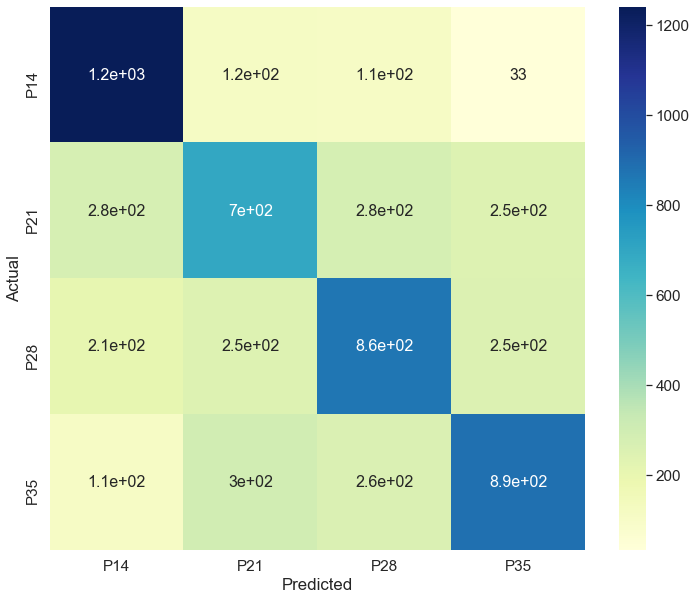

In [85]:
confusion_matrix(y_test, pred)
pl.figure(figsize=(12,10))
cm_array = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

pl.show()

In [86]:
explainer = shap.TreeExplainer(booster) #using booster instead of bst
shap_values = explainer.shap_values(X_test[features])

In [87]:
%matplotlib inline
import matplotlib.pyplot as pl

In [88]:
cP14 = '#E69F00'
cP21 = '#56B4E9'
cP28 = '#009E73'
cP35 = '#CC79A7'
colors = [cP14, cP21, cP28, cP35]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [89]:
class_inds

array([0, 3, 2, 1])

In [30]:
# sn.reset_orig() # Reset matplot lib to no longer use seaborn

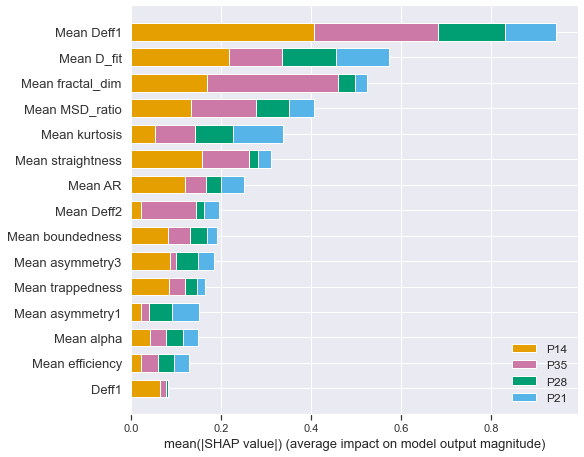

In [90]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [324]:
# This is optional, but right units of diffusion are in piels^2/frame.
# To convert, There are 0.07 um/pixel and 30.3 frames/s in videos.
# *This may be different depending on zoom of camera, make sure to ask 
# whoever took video.
X_test['Mean Deff1'] = X_test['Mean Deff1']*(0.07**2)/30.3
X_test['Mean D_fit'] = X_test['Mean D_fit']*(0.07**2)/30.3


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


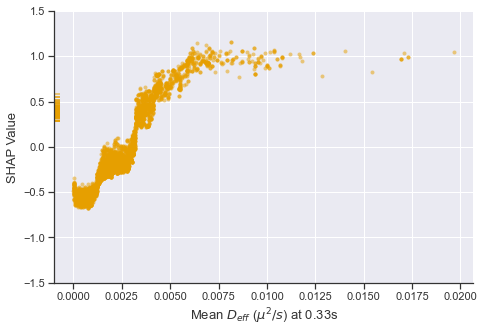

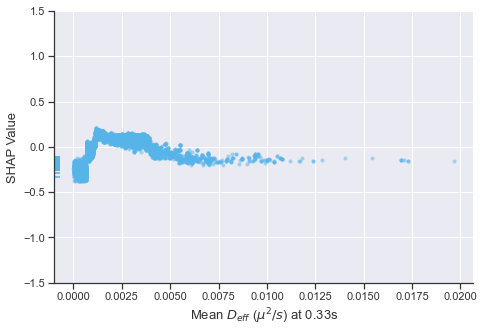

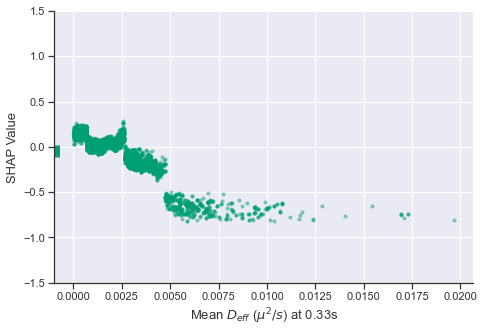

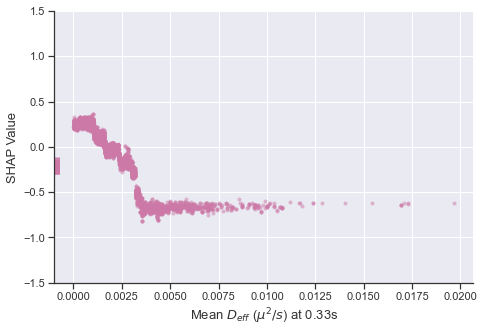

In [329]:
pl.ioff()
%matplotlib inline

figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean Deff1", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{eff}$ ($\mu^2/s$) at 0.33s')
    ax.set_ylabel('SHAP Value')

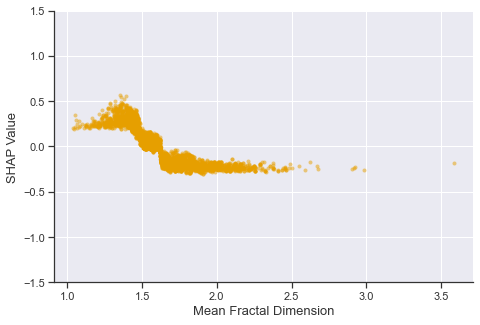

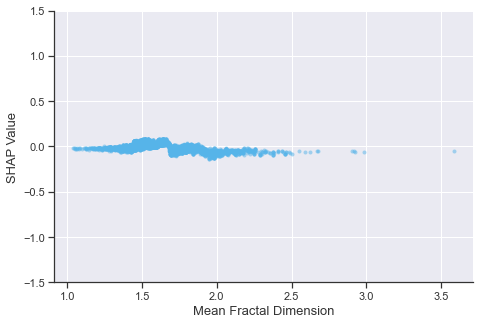

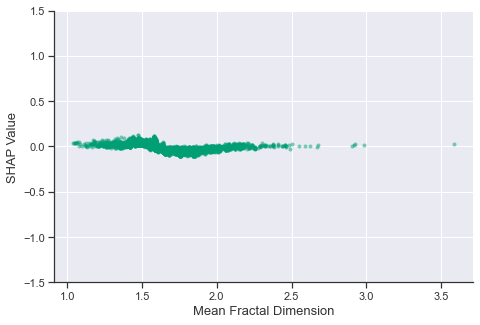

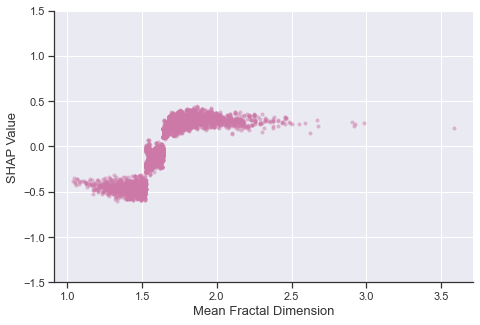

In [126]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean fractal_dim", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax, show=False)
    ax.set_xlabel('Mean Fractal Dimension')
    ax.set_ylabel('SHAP Value')

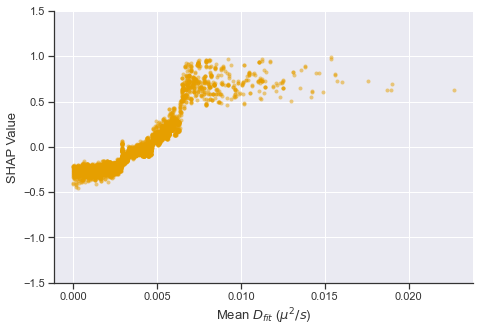

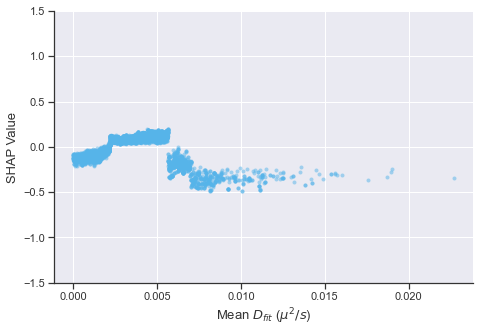

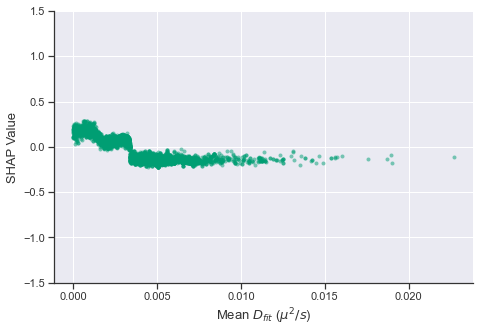

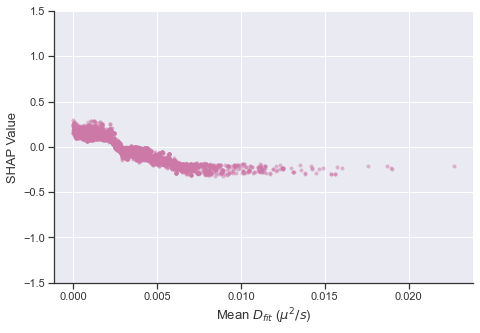

In [335]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean D_fit", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{fit}$ ($\mu^2/s$)')
    ax.set_ylabel('SHAP Value')

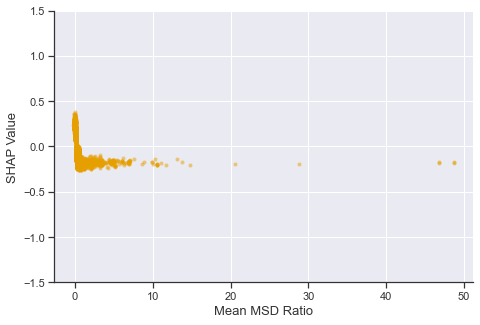

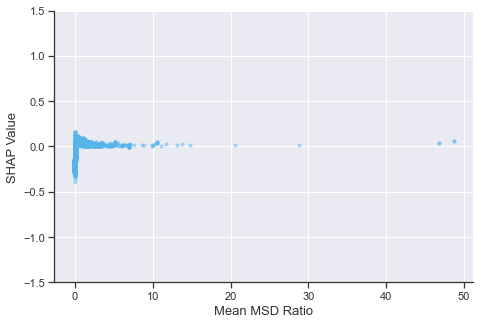

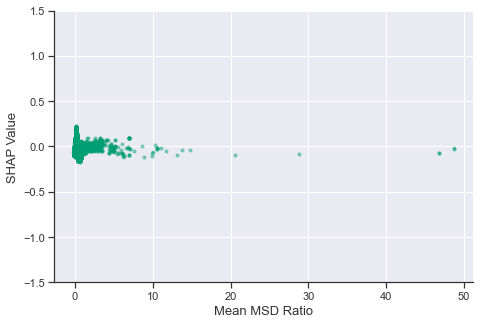

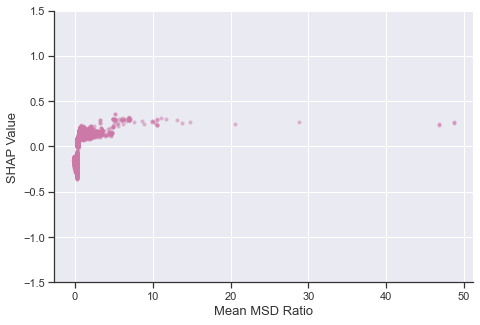

In [334]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean MSD_ratio", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax, show=False)
    ax.set_xlabel('Mean MSD Ratio')
    ax.set_ylabel('SHAP Value')

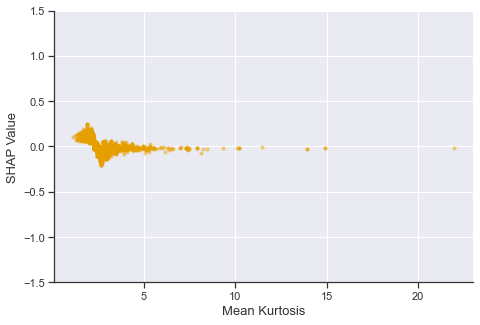

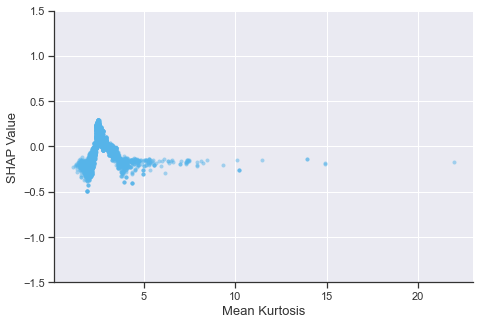

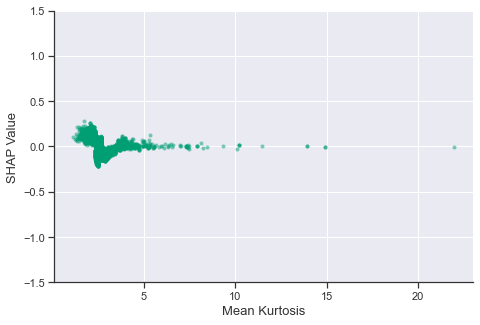

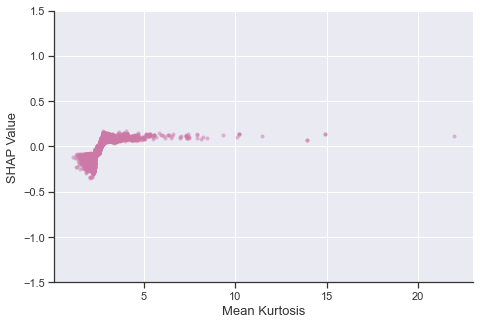

In [125]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean kurtosis", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax, show=False)
    ax.set_xlabel('Mean Kurtosis')
    ax.set_ylabel('SHAP Value')
    

Text(0.5, 1.0, 'Top 5 Features for P14 Pup')

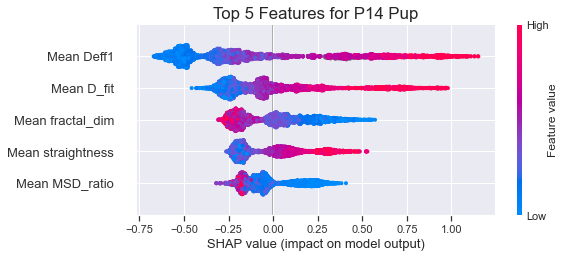

In [91]:
figsize = (7.5, 5)
fig = pl.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[0], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P14', show=False)
ax.set_title('Top 5 Features for P14 Pup')

Text(0.5, 1.0, 'Top 5 Features for P21 Pup')

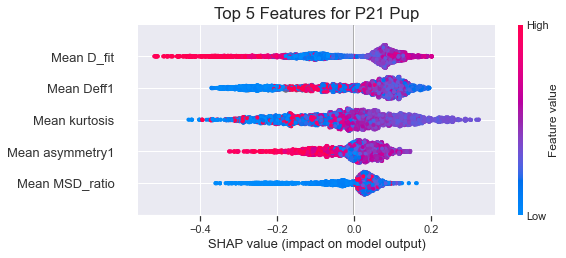

In [92]:
figsize = (7.5, 5)
fig = pl.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[1], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P21', show=False)
ax.set_title('Top 5 Features for P21 Pup')

Text(0.5, 1.0, 'Top 5 Features for P28 Pup')

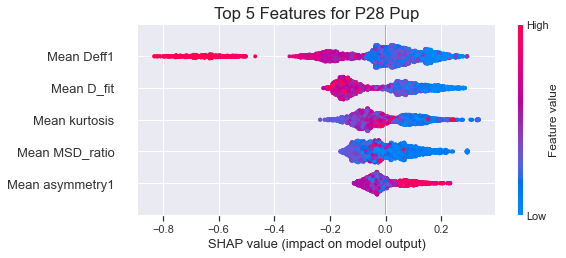

In [93]:
figsize = (7.5, 5)
fig = pl.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[2], X_test[features], max_display=5, class_names = class_names, title='SHAP Value for P28', show=False)
ax.set_title('Top 5 Features for P28 Pup')

Text(0.5, 1.0, 'Top 5 Features for P35 Pup')

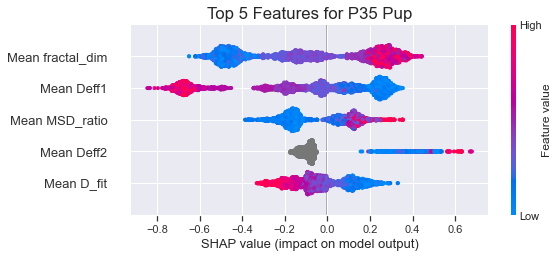

In [94]:
figsize = (7.5, 5)
fig = pl.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[3], X_test[features], max_display=5, class_names=class_names, title='SHAP Value for P35', show=False)
ax.set_title('Top 5 Features for P35 Pup')

In [279]:
from modules import anim_plot_changed
from importlib import reload
reload(anim_plot_changed)

_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[1], top_feat[2]])
_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[2], top_feat[3]])
_ = anim_plot_changed.rotate_3d(results, [top_feat[1], top_feat[2], top_feat[3]])

ImportError: cannot import name 'anim_plot_changed' from 'modules' (unknown location)

In [280]:
from modules import anim_plot_changed
from importlib import reload
reload(anim_plot_changed)

_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[1], top_feat[2]], anim_param={'frames':np.arange(0,720,1)}, save_param={'filename':'This_is_a_test.gif','fps':50})

ImportError: cannot import name 'anim_plot_changed' from 'modules' (unknown location)

In [281]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [286]:
from sklearn import model

ImportError: cannot import name 'model' from 'sklearn' (C:\ProgramData\Miniconda3\lib\site-packages\sklearn\__init__.py)

In [288]:
print(model.feature_importances_)

NameError: name 'model' is not defined

In [283]:
# Feature search (new) -------not in file--------: 
import operator
from sklearn.metrics import accuracy_score

def feature_thresholding_helper(X_train, X_test, X_val, new_feat):
    dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
    dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
    dval = xgb.DMatrix(X_val[new_feat], label=y_val)
    return dtrain, dtest, dval

def feature_thresholding(X_train, y_train, X_test, y_test, X_val, y_val, params, features, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mlogloss', 'merror'}, thresh=np.arange(0,.1,.002)):
    best_thresh = -1
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        best_eval = -np.inf
        eval_f = operator.gt
    else: 
        best_eval = np.inf
        eval_f = operator.lt
    
    best_eval = -np.inf
    eval_f = operator.gt
    
    for t in thresh:
        print(f"Using thresh = {t} ",end = '| ')
        new_feat = list(np.array(features)[np.array(model.feature_importances_ > t)])

#         cv_model = cv(params, 
#                       X_train, 
#                       y_train, 
#                       features=new_feat, 
#                       nfold=nfold, 
#                       num_boost_round=num_boost_round, 
#                       early_stopping_rounds=early_stopping_rounds, 
#                       metrics=metrics) 
#         cv_eval = cv_model[f"test-{'merror'}-mean"].min()
#         print(f"Eval = {cv_eval} ", end = '| ')
#         if eval_f(cv_eval, best_eval):
#             best_thresh = t
#             best_eval = cv_eval

        dtrain, dtest, dval = feature_thresholding_helper(X_train, X_test, X_val, new_feat)
        evals = [(dtrain, 'train'), (dval, 'eval')]
        bst2 = xgb.train(best_param, dtrain, 1500, evals, early_stopping_rounds=3, verbose_eval=False)
        ######
        label = dtest.get_label()
        ypred1 = bst2.predict(dtest)
        # by default, we predict using all the trees
        pred2 = [np.where(x == np.max(x))[0][0] for x in ypred1]

        cv_eval = accuracy_score(y_test, pred2)
        if eval_f(cv_eval, best_eval):
            best_thresh = t
            best_eval = cv_eval
            
        print(f"Best eval = {best_eval}, Best threshold = {best_thresh}")
    print(f"Features used:\n{np.array(features)[np.array(model.feature_importances_ > best_thresh)]}")
    return list(np.array(features)[np.array(model.feature_importances_ > best_thresh)])

new_feat = feature_thresholding(X_train, y_train, X_test, y_test, X_val, y_val, best_param, features)

Using thresh = 0.0 | 

NameError: name 'model' is not defined

In [362]:
new_feat = list(np.array(features)[np.array(model.feature_importances_ > best_thresh)])

In [371]:
cv_model = cv(best_param, 
              X_train, 
              y_train, 
              features=new_feat, 
              nfold=5, 
              num_boost_round=best_boost_rounds, 
              early_stopping_rounds=3, 
              metrics={'mlogloss', 'merror'}) 
cv_model

In [374]:
dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
dval = xgb.DMatrix(X_val[new_feat], label=y_val)

In [375]:
evals = [(dtrain, 'train'), (dval, 'eval')]
num_round = best_boost_rounds
bst = xgb.train(best_param, dtrain, num_round, evals, early_stopping_rounds=3, )


######
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]

[0]	train-mlogloss:1.38480	eval-mlogloss:1.38538
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.38298	eval-mlogloss:1.38424
[2]	train-mlogloss:1.38080	eval-mlogloss:1.38266
[3]	train-mlogloss:1.37877	eval-mlogloss:1.38131
[4]	train-mlogloss:1.37662	eval-mlogloss:1.37985
[5]	train-mlogloss:1.37462	eval-mlogloss:1.37853
[6]	train-mlogloss:1.37239	eval-mlogloss:1.37699
[7]	train-mlogloss:1.37065	eval-mlogloss:1.37585
[8]	train-mlogloss:1.36888	eval-mlogloss:1.37481
[9]	train-mlogloss:1.36682	eval-mlogloss:1.37343
[10]	train-mlogloss:1.36465	eval-mlogloss:1.37196
[11]	train-mlogloss:1.36287	eval-mlogloss:1.37079
[12]	train-mlogloss:1.36106	eval-mlogloss:1.36964
[13]	train-mlogloss:1.35940	eval-mlogloss:1.36858
[14]	train-mlogloss:1.35725	eval-mlogloss:1.36707
[15]	train-mlogloss:1.35526	eval-mlogloss:1.36570
[16]	train-mlogloss:1.35396	eval-mlogloss:1.36495
[17]	train

[160]	train-mlogloss:1.15536	eval-mlogloss:1.24018
[161]	train-mlogloss:1.15457	eval-mlogloss:1.23980
[162]	train-mlogloss:1.15354	eval-mlogloss:1.23918
[163]	train-mlogloss:1.15256	eval-mlogloss:1.23870
[164]	train-mlogloss:1.15174	eval-mlogloss:1.23827
[165]	train-mlogloss:1.15069	eval-mlogloss:1.23765
[166]	train-mlogloss:1.14976	eval-mlogloss:1.23721
[167]	train-mlogloss:1.14871	eval-mlogloss:1.23654
[168]	train-mlogloss:1.14776	eval-mlogloss:1.23597
[169]	train-mlogloss:1.14668	eval-mlogloss:1.23530
[170]	train-mlogloss:1.14568	eval-mlogloss:1.23474
[171]	train-mlogloss:1.14480	eval-mlogloss:1.23432
[172]	train-mlogloss:1.14380	eval-mlogloss:1.23378
[173]	train-mlogloss:1.14274	eval-mlogloss:1.23314
[174]	train-mlogloss:1.14192	eval-mlogloss:1.23272
[175]	train-mlogloss:1.14083	eval-mlogloss:1.23220
[176]	train-mlogloss:1.13996	eval-mlogloss:1.23166
[177]	train-mlogloss:1.13914	eval-mlogloss:1.23123
[178]	train-mlogloss:1.13832	eval-mlogloss:1.23083
[179]	train-mlogloss:1.13733	ev

[321]	train-mlogloss:1.03255	eval-mlogloss:1.17763
[322]	train-mlogloss:1.03186	eval-mlogloss:1.17733
[323]	train-mlogloss:1.03137	eval-mlogloss:1.17713
[324]	train-mlogloss:1.03072	eval-mlogloss:1.17685
[325]	train-mlogloss:1.03011	eval-mlogloss:1.17658
[326]	train-mlogloss:1.02961	eval-mlogloss:1.17643
[327]	train-mlogloss:1.02913	eval-mlogloss:1.17623
[328]	train-mlogloss:1.02854	eval-mlogloss:1.17595
[329]	train-mlogloss:1.02801	eval-mlogloss:1.17577
[330]	train-mlogloss:1.02746	eval-mlogloss:1.17553
[331]	train-mlogloss:1.02690	eval-mlogloss:1.17528
[332]	train-mlogloss:1.02638	eval-mlogloss:1.17507
[333]	train-mlogloss:1.02576	eval-mlogloss:1.17486
[334]	train-mlogloss:1.02526	eval-mlogloss:1.17467
[335]	train-mlogloss:1.02464	eval-mlogloss:1.17441
[336]	train-mlogloss:1.02399	eval-mlogloss:1.17416
[337]	train-mlogloss:1.02350	eval-mlogloss:1.17396
[338]	train-mlogloss:1.02295	eval-mlogloss:1.17370
[339]	train-mlogloss:1.02237	eval-mlogloss:1.17345
[340]	train-mlogloss:1.02175	ev

[482]	train-mlogloss:0.95478	eval-mlogloss:1.14879
[483]	train-mlogloss:0.95443	eval-mlogloss:1.14865
[484]	train-mlogloss:0.95396	eval-mlogloss:1.14853
[485]	train-mlogloss:0.95364	eval-mlogloss:1.14845
[486]	train-mlogloss:0.95325	eval-mlogloss:1.14830
[487]	train-mlogloss:0.95290	eval-mlogloss:1.14822
[488]	train-mlogloss:0.95249	eval-mlogloss:1.14813
[489]	train-mlogloss:0.95208	eval-mlogloss:1.14798
[490]	train-mlogloss:0.95167	eval-mlogloss:1.14789
[491]	train-mlogloss:0.95124	eval-mlogloss:1.14773
[492]	train-mlogloss:0.95081	eval-mlogloss:1.14760
[493]	train-mlogloss:0.95042	eval-mlogloss:1.14750
[494]	train-mlogloss:0.95006	eval-mlogloss:1.14736
[495]	train-mlogloss:0.94961	eval-mlogloss:1.14720
[496]	train-mlogloss:0.94926	eval-mlogloss:1.14714
[497]	train-mlogloss:0.94885	eval-mlogloss:1.14701
[498]	train-mlogloss:0.94841	eval-mlogloss:1.14687
[499]	train-mlogloss:0.94798	eval-mlogloss:1.14674
[500]	train-mlogloss:0.94759	eval-mlogloss:1.14656
[501]	train-mlogloss:0.94715	ev

[643]	train-mlogloss:0.90179	eval-mlogloss:1.13538
[644]	train-mlogloss:0.90152	eval-mlogloss:1.13526
[645]	train-mlogloss:0.90119	eval-mlogloss:1.13516
[646]	train-mlogloss:0.90094	eval-mlogloss:1.13507
[647]	train-mlogloss:0.90069	eval-mlogloss:1.13499
[648]	train-mlogloss:0.90046	eval-mlogloss:1.13493
[649]	train-mlogloss:0.90016	eval-mlogloss:1.13489
[650]	train-mlogloss:0.89983	eval-mlogloss:1.13481
[651]	train-mlogloss:0.89959	eval-mlogloss:1.13476
[652]	train-mlogloss:0.89935	eval-mlogloss:1.13473
[653]	train-mlogloss:0.89914	eval-mlogloss:1.13468
[654]	train-mlogloss:0.89889	eval-mlogloss:1.13463
[655]	train-mlogloss:0.89863	eval-mlogloss:1.13463
[656]	train-mlogloss:0.89845	eval-mlogloss:1.13461
[657]	train-mlogloss:0.89817	eval-mlogloss:1.13458
[658]	train-mlogloss:0.89783	eval-mlogloss:1.13455
[659]	train-mlogloss:0.89757	eval-mlogloss:1.13451
[660]	train-mlogloss:0.89726	eval-mlogloss:1.13443
[661]	train-mlogloss:0.89701	eval-mlogloss:1.13442
[662]	train-mlogloss:0.89673	ev

In [376]:
# print('0 == {}'.format(le.inverse_transform([0])))
# print('1 == {}'.format(le.inverse_transform([1])))
# print('2 == {}'.format(le.inverse_transform([2])))
# print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6306    0.7071    0.6667       898
         P21     0.4256    0.5091    0.4636       876
         P28     0.3953    0.2662    0.3181       943
         P35     0.5202    0.5352    0.5276       938

    accuracy                         0.5018      3655
   macro avg     0.4929    0.5044    0.4940      3655
weighted avg     0.4924    0.5018    0.4924      3655



In [327]:
# Running CV with newly thresholded features; using new seed of 123 to get different unique GS hyperparams
best_model2, best_param2, best_eval2, best_boost_rounds2 = xgb_paramsearch(X_train, y_train, new_feat, init_params=best_param, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mlogloss', 'merror'}, use_gpu='True', seed=123)

Using CV with subsample={0.7}, colsample_bytree={0.7}
New best param found: mlogloss = {1.05563476842045}, boost_rounds = {1116}
Using CV with subsample={0.7}, colsample_bytree={0.8}
Using CV with subsample={0.7}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={0.8}
Using CV with subsample={1.0}, colsample_bytree={0.7}
Using CV with subsample={1.0}, colsample_bytree={0.6}
Using CV with max_depth={1}, min_child_weight={2}
Using CV with max_depth={4}, min_child_weight={10}
Using CV with max_depth={4}, min_child_weight={7}
Using CV with max_depth={1}, min_child_weight={3}
Using CV with max_depth={10}, min_child_weight={4}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={4}, min_child_weight={4}
Using CV with max_depth={1}, min_child_weight={4}
Using CV with max_depth={1}, min_child_weight={7}
Using CV with max_depth={1}, min_child_

Using CV with max_depth={10}, min_child_weight={0}
Using CV with max_depth={10}, min_child_weight={9}
Using CV with max_depth={10}, min_child_weight={2}
Using CV with eta={0.3}, gamma={1.0}
Using CV with eta={0.3}, gamma={0.5}
Using CV with eta={0.3}, gamma={0}
Using CV with eta={0.3}, gamma={0.2}
Using CV with eta={0.005}, gamma={0.01}
Using CV with eta={0.3}, gamma={0.01}
Using CV with eta={0.3}, gamma={0.001}
Using CV with eta={0.005}, gamma={0}
Using CV with eta={0.005}, gamma={0.5}
Using CV with subsample={0.8}, colsample_bytree={1.0}
Using CV with subsample={0.7}, colsample_bytree={0.7}
Using CV with subsample={0.8}, colsample_bytree={0.6}
Using CV with subsample={0.8}, colsample_bytree={0.9}
Using CV with subsample={1.0}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={0.6}
Using CV with subsample={1.0}, colsample_bytree={0.8}
Using CV with max_depth={6}, min_child_weight={4}
Using CV with max_depth={10}, min_child_weight={5}
Using CV with max_depth={1}, 

In [331]:
seed = 1234
np.random.seed(seed)
train_split = 0.7
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])
training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)
X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)
y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']
dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
dval = xgb.DMatrix(X_val[new_feat], label=y_val)

In [351]:
best_param2={'max_depth': 5,
             'eta': 0.005,
             'min_child_weight': 10,
             'verbosity': 0,
             'objective': 'multi:softprob',
             'num_class': 4,
             'silent': 'True',
             'gamma': 5,
             'subsample': 0.6,
             'colsample_bytree': 0.5,
             'eval_metric': 'mlogloss',
             'gpu_id': 0,
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor'}

In [95]:
evals = [(dtrain, 'train'), (dval, 'eval')]
num_round = best_boost_rounds
bst2 = xgb.train(best_param, dtrain, num_round, evals, early_stopping_rounds=3, )


######
label = dtest.get_label()
ypred1 = bst2.predict(dtest)
# by default, we predict using all the trees
pred2 = [np.where(x == np.max(x))[0][0] for x in ypred1]

print("Accuracy:",metrics.accuracy_score(y_test, pred2))

NameError: name 'best_param' is not defined

In [354]:
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred2, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6306    0.7071    0.6667       898
         P21     0.4256    0.5091    0.4636       876
         P28     0.3953    0.2662    0.3181       943
         P35     0.5202    0.5352    0.5276       938

    accuracy                         0.5018      3655
   macro avg     0.4929    0.5044    0.4940      3655
weighted avg     0.4924    0.5018    0.4924      3655



In [ ]:
# param2 = {'max_depth': 2,
#          'eta': 0.005,

#          'min_child_weight': 0,
#          'verbosity': 0,
#          'objective': 'multi:softprob',
#          'num_class': 4,
#          'silent': 'True',
#          'gamma': 5,
#          'subsample': 0.25,
#          'colsample_bytree': 0.3,
#          'colsample_bynode':.5,
#          'reg_alpha': 0}

In [ ]:
from sklearn.metrics import accuracy_score

model_final = XGBClassifier(**param2)
new_feat = np.array(features)[np.array(model.feature_importances_ > t)]
eval_set = [(X_train[new_feat], y_train), (X_test[new_feat], y_test)]
model_final.fit(X_train[new_feat], y_train, verbose=False, eval_set=eval_set, eval_metric=["merror", 'mlogloss'])
y_pred_f = model_final.predict(X_test[new_feat])
accuracy = accuracy_score(y_test, y_pred_f)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = model_final.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = pl.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()

pl.ylabel('Log Loss')
pl.title('XGBoost Log Loss')
pl.show()

In [ ]:
sorted(dict_importance, key=dict_importance.get, reverse=True)[:5]

In [ ]:
    new_feat = np.array(features)[np.array(model.feature_importances_ > best_thresh)]
model2.fit(X_train[new_feat], y_train, verbose=False, eval_set=[(X_val[new_feat],y_val)], eval_metric='mlogloss')
pred3 = model2.predict(X_test[new_feat])
acc = metrics.accuracy_score(y_test, pred3)
print("Accuracy:",metrics.accuracy_score(y_test, pred3))